<a href="https://colab.research.google.com/github/pachterlab/CGCCP_2023/blob/main/ShortDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple biVI Training


This notebook is a short demonstration of how to train a biVI model with a particular generative distribution. 


Sections:

1. Load in and pre-process data
2. Train the model
3. Visualize results


In [71]:
import time
t1 = time.time()

# Install packages, import data



## Clone Github Repository

In [72]:
!git clone https://github.com/pachterlab/CGCCP_2023.git
%cd /content/CGCCP_2023

Cloning into 'CGCCP_2023'...
remote: Enumerating objects: 950, done.
remote: Counting objects: 100% (950/950), done.
remote: Compressing objects: 100% (504/504), done.
remote: Total 950 (delta 484), reused 815 (delta 426), pack-reused 0
Receiving objects: 100% (950/950), 39.86 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (484/484), done.
/content/CGCCP_2023


## Load PBMC data

Load in aligned single cell data. 

As in the comparison demo notebook, the raw data is the available [1k PBMC dataset from 10x Genomics](https://www.10xgenomics.com/resources/datasets/1-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0). Data was processed using kallisto bustools to obtain unspliced and spliced count matrices as described in [Gorin et. al, 2022](https://www.cell.com/biophysreports/fulltext/S2667-0747(22)00054-4). 

In [73]:
%%bash

mkdir data
cd data

wget -q --content-disposition "https://figshare.com/ndownloader/files/38765802"


cd ..

mkdir: cannot create directory ‘data’: File exists


## Install packages

Install biVI and its dependencies from the local source code.

In [74]:
%%bash
# Install BIVI and dependencies
pip install -q ./Code
pip install -q -r Code/requirements.txt

In [75]:
# import packages

# system
import os, sys

# numbers
import numpy as np

#sc
import anndata
import scanpy as sc

# Plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
    
# biVI
from BIVI import biVI

In [76]:
# run if matplotlib gives errors
%%bash

# Run if matplotlib is giving error with _png
pip uninstall -q --yes matplotlib
pip install -q matplotlib==3.1.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [77]:
data_path = 'data/pbmc_1k_v3.loom'
adata = sc.read_loom(data_path)


if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

adata.var_names_make_unique()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [78]:
adata

AnnData object with n_obs × n_vars = 1200 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

# Process data

Process data to include only high quality cells. Processing based on spliced matrix. 


Use Scanpy to filter for cells with a minimum of 200 genes, and for genes that occur in a minimum of 3 cells. Then, annotate mitochondrial genes and remove cells if more than 30% of their counts are of mitochondrial gene. Also remove cells with fewer than 1,000 counts (plots showing how these cutoffs were determined are included in Demo.ipynb).

Next, normalize by ensuring the counts for all cells sum to 10,000 and log1p transforming the data. 

Finally, select top 2,000 highly variable genes and subset the data matrix for those genes. 


In [79]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


## Further filtering
adata = adata[adata.obs.total_counts > 1000, :]
adata = adata[adata.obs.pct_counts_mt < 30, :]

# Normalize to get highly variable genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to highly variable genes
adata = adata[:, adata.var.highly_variable]

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Concatenate unspliced and spliced matrices 

Finally, concatenate adata unspliced and spliced count layers (raw) for scVI training. Also ensure that "counts" layer used for training includes raw counts.  

In [80]:
adata_old = adata
# separate spliced and unspliced layers
adata_spliced   = anndata.AnnData(adata.layers['spliced'])
adata_unspliced = anndata.AnnData(adata.layers['unspliced'])

adata_spliced.var = adata.var.copy()
adata_unspliced.var = adata.var.copy()
adata_spliced.var['Spliced']   = True
adata_unspliced.var['Spliced'] = False

# add a -u to unspliced gene names
adata_unspliced.var_names = adata_unspliced.var_names + '-u'


# NOTICE -- ORDER IS IMPORTANT -- concatenate so that matrices are ordered unspliced, spliced
adata = anndata.concat([adata_unspliced,adata_spliced],axis=1)

## Change AnnData expression to raw counts for training
adata.layers["counts"] = adata.X.copy() # preserve counts

# Update obs,var
adata.obs = adata_old.obs.copy()

# Train biVI Model


Train a biVI model. 

In [81]:
# check GPU availability
import torch 
import torch.nn as nn
import torch.nn.functional as F
memory_used = torch.cuda.memory_allocated()


# training split
from sklearn.model_selection import StratifiedKFold

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try: 
  print('cuda available:',torch.cuda.is_available())
  print('device count:',torch.cuda.device_count())
  print('current device:',torch.cuda.current_device())
except:
  pass

cuda available: True
device count: 1
current device: 0


In [82]:
# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata,layer="counts")

 ## Define training and model hyperparameters

In [83]:
model_args = {    'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene',
                  'n_hidden'     : 128,
                  'dropout_rate' :  0.1,
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  }

# training plan parameters
max_epochs = 10

plan_kwargs = {'lr' : 0.001,
               'n_epochs_kl_warmup' : max_epochs/2,
                }

## Define biVI model

biVI allows three different generative hypotheses to be parameterized.

Argument, "mode" takes three possible strings: 


1. "Bursty" : **Bursty** model of transcription
2. "NBcorr" : **Extrinsic** model of transcription, in which nascent and mature RNA are distributed according to two correlated Negative Binomial distributions
3. "Poisson" : **Constitutive** model of transcription, in which nascent and mature RNA are distributed according to two independent Poisson distributions

In [84]:
model = biVI.biVI(adata,mode='Bursty',**model_args)

4000


## Train! 

In [86]:
model.train(max_epochs = 100,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 100/100: 100%|██████████| 100/100 [01:39<00:00,  1.07it/s, loss=1.22e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s, loss=1.22e+03, v_num=1]


## How did it do? 

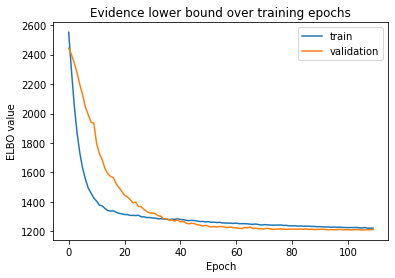

In [89]:
# plot history
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="validation")
plt.title("Evidence lower bound over training epochs")
plt.xlabel('Epoch')
plt.ylabel('ELBO value')
plt.legend()

In [90]:
# extract latent space and parameters, can use for clustering, etc.
latent_representation = model.get_latent_representation(adata)

# for ALL models, returns spliced and unspliced means 
# for Bursty Model: burst size, relative splicing rate, relative degradation rate
# for Constitutive Model: relative splicing rate, relative degradation rate
# for Extrinsic Model: mean of gamma distributed transcriptional rates, relative splicing rate, relative degradation rate

parameters = model.get_likelihood_parameters(adata)

## Plot burst size and relative degradation rate across all cells

Plot parameters for marker gene 'CD2', which marks T-cells, across all cells. 


Cells separate out in parameter space! Likely the cells that have separated by larger burst size are T-cells.  

In [91]:
# locate the marker gene
cd2_index_u,cd2_index_s = np.where(adata.var['gene_name']=='CD2')[0][0],np.where(adata.var['gene_name']=='CD2')[0][1]

Text(0.5, 1.0, 'Inferred parameters for CD2 across all cells')

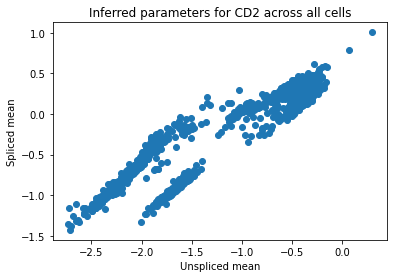

In [ ]:
plt.scatter(np.log10(parameters[''][:,cd2_index_u]),np.log10(parameters['mean'][:,cd2_index_s]))
plt.xlabel('Unspliced mean')
plt.ylabel('Spliced mean')
plt.title('Inferred parameters for CD2 across all cells')